# IMPORT

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
from deepmeg.preprocessing.transforms import one_hot_encoder, one_hot_decoder, zscore
from deepmeg.data.datasets import EpochsDataset
import math
from deepmeg.training.callbacks import Callback, EarlyStopping, L2Reg, PrintingCallback
from deepmeg.models import BaseModel
from deepmeg.utils.viz import plot_metrics
import pandas as pd
from sklearn.metrics import confusion_matrix
from utils.viz import plot_distribution
from deepmeg.preprocessing.transforms import one_hot_decoder



def accuracy(predictions: torch.Tensor, targets: torch.Tensor) -> float:
    """
    Calculate the accuracy of predictions.

    Args:
        predictions (torch.Tensor): The predicted scores from the model.
        targets (torch.Tensor): The true target labels.

    Returns:
        float: The accuracy of the predictions.
    """
    # Convert one-hot encoded labels to class indices
    targets = torch.argmax(targets, dim=1)

    # Compute predicted class indices
    _, predicted = torch.max(predictions, dim=1)

    # Compute accuracy
    correct = torch.sum(predicted == targets)
    total = targets.shape[0]
    accuracy = correct / total

    return accuracy


def compute_confusion_matrix(y_true: np.ndarray, y_pred: np.ndarray, labels: list[int | str] = None):
    """
    Compute a confusion matrix and return it as a pandas DataFrame.

    Args:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.
        labels (list, optional): List of labels to include in the confusion matrix.
                                If None, all unique labels present in y_true and y_pred will be used.

    Returns:
        pd.DataFrame: Confusion matrix as a DataFrame.
    """
    conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)

    if labels is None:
        labels = sorted(set(np.concatenate([y_true, y_pred], axis=0)))

    conf_matrix_df = pd.DataFrame(conf_matrix, index=labels, columns=labels)

    return conf_matrix_df


def plot_confusion_matrix(confusion_matrix_df: pd.DataFrame, title: str = "Confusion Matrix Heatmap", cbar: bool = False) -> plt.Figure:
    """
    Visualize a confusion matrix stored in a pandas DataFrame using a heatmap.

    Args:
        confusion_matrix_df (pd.DataFrame): Confusion matrix as a DataFrame.
        title (str, optional): Title for the plot. Defaults to "Confusion Matrix Heatmap".
        cbar (bool, optional): Whether to show a colorbar. Defaults to False.

    Returns:
        plt.Figure: Matplotlib Figure object containing the confusion matrix plot.
    """
    fig, ax = plt.subplots(figsize=(10, 7))
    im = ax.imshow(confusion_matrix_df, interpolation="nearest", cmap=plt.cm.Blues)
    ax.set_title(title)
    if cbar:
        cbar = ax.figure.colorbar(im, ax=ax)
    tick_marks = range(len(confusion_matrix_df.columns))

    if any([not isinstance(column, (int, float)) and len(column) > 5 for column in confusion_matrix_df.columns]):
        ax.set_xticks(tick_marks)
        ax.set_xticklabels(confusion_matrix_df.columns, rotation=45)
    else:
        ax.set_xticks(tick_marks)
        ax.set_xticklabels(confusion_matrix_df.columns)

    ax.set_yticks(tick_marks)
    ax.set_yticklabels(confusion_matrix_df.index)

    for i in range(len(confusion_matrix_df.index)):
        for j in range(len(confusion_matrix_df.columns)):
            cell_value = confusion_matrix_df.iloc[i, j]
            text_color = "#eee" if cell_value > confusion_matrix_df.max().max() / 2 else "#333"
            ax.text(j, i, str(cell_value), ha="center", va="center", color=text_color)

    ax.set_xlabel("Predicted Labels")
    ax.set_ylabel("True Labels")
    fig.tight_layout()

    return fig


# Encoder-Decoder LSTM with Bahdanau Attention

In [2]:
class BahdanauAttention(nn.Module):
    def __init__(self, encoder_hidden_size: int, decoder_hidden_size: int, attention_size: int, bias: bool = True):
        """
        Bahdanau Attention Mechanism.

        Args:
            encoder_hidden_size (int): The size of the encoder hidden states.
            decoder_hidden_size (int): The size of the decoder hidden states.
            attention_size (int): The size of the attention vector.
        """
        super(BahdanauAttention, self).__init__()
        self.encoder_hidden_size = encoder_hidden_size
        self.decoder_hidden_size = decoder_hidden_size
        self.attention_size = attention_size

        self.W_enc = nn.Linear(encoder_hidden_size, attention_size)
        self.W_dec = nn.Linear(decoder_hidden_size, attention_size)
        self.V = nn.Linear(attention_size, 1)

        if bias:
            self.bias = nn.Parameter(torch.empty(attention_size))
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.W_dec.weight)
            if fan_in != 0:
                bound = 1 / math.sqrt(fan_in)
                nn.init.uniform_(self.bias, -bound, bound)
        else:
            self.register_parameter('bias', None)

    def forward(self, encoder_hidden_states: torch.Tensor, decoder_hidden_state: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Perform the forward pass of the Bahdanau Attention Mechanism.

        Args:
            encoder_hidden_states (torch.Tensor): The encoder hidden states. Shape: (batch_size, seq_length, encoder_hidden_size)
            decoder_hidden_state (torch.Tensor): The current decoder hidden state. Shape: (batch_size, decoder_hidden_size)

        Returns:
            context_vector (torch.Tensor): The context vector for the current decoder step. Shape: (batch_size, encoder_hidden_size)
            attention_weights (torch.Tensor): The attention weights over the encoder hidden states. Shape: (batch_size, seq_length)
        """
        seq_length = encoder_hidden_states.size(1)

        # Calculate alignment scores
        encoder_score = self.W_enc(encoder_hidden_states)  # (batch_size, seq_length, attention_size)

        decoder_score = self.W_dec(decoder_hidden_state)  # (batch_size, 1, attention_size)

        # Combine encoder and decoder scores and apply the non-linearity
        b = self.bias if self.bias is not None else 0
        alignment_scores = torch.tanh(encoder_score + torch.unsqueeze(decoder_score, 1) + b)  # (batch_size, seq_length, attention_size)

        # Calculate attention weights
        attention_weights = self.V(alignment_scores).squeeze(-1)  # (batch_size, seq_length)

        # Apply softmax to get normalized attention weights
        attention_weights = torch.softmax(attention_weights, dim=-1)  # (batch_size, seq_length)

        # Calculate context vector as a weighted sum of encoder hidden states
        context_vector = torch.bmm(attention_weights.unsqueeze(1), encoder_hidden_states.view(-1, seq_length, self.encoder_hidden_size))
        context_vector = context_vector.squeeze(1)  # (batch_size, encoder_hidden_size)

        return context_vector, attention_weights


class EncoderDecoderLSTM(nn.Module):
    def __init__(self, input_size: int, encoder_hidden_size: int, decoder_hidden_size: int, attention_size: int):
        """
        Encoder-Decoder LSTM with Bahdanau Attention.

        Args:
            input_size (int): The size of the input features.
            encoder_hidden_size (int): The size of the encoder hidden states.
            decoder_hidden_size (int): The size of the decoder hidden states.
            attention_size (int): The size of the attention vector.
        """
        super(EncoderDecoderLSTM, self).__init__()
        self.encoder_hidden_size = encoder_hidden_size
        self.decoder_hidden_size = decoder_hidden_size
        self.attention_size = attention_size

        self.encoder_lstm = nn.LSTM(input_size, encoder_hidden_size, batch_first=True)
        self.attention = BahdanauAttention(encoder_hidden_size, decoder_hidden_size, attention_size)

        self.decoder_lstm = nn.LSTMCell(decoder_hidden_size + encoder_hidden_size, decoder_hidden_size)
        self._attention_weights = None

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Perform the forward pass of the Encoder-Decoder LSTM.

        Args:
            x (torch.Tensor): The input tensor. Shape: (n_batch, n_times, n_features)

        Returns:
            output (torch.Tensor): The output tensor. Shape: (n_batch, n_times, decoder_hidden_size)
        """
        n_batch, n_times, n_features = x.size()

        # Encoder LSTM
        encoder_hidden_states, (h_n_enc, c_n_enc) = self.encoder_lstm(x)

        # Decoder LSTM initial hidden state
        h_n_dec, c_n_dec = self.decoder_lstm(torch.zeros(n_batch, self.decoder_hidden_size + self.encoder_hidden_size).to(x.device))

        # Output tensor to store predictions
        output = torch.zeros(n_batch, n_times, self.decoder_hidden_size).to(x.device)
        attention_weights = list()

        # Iterate over each time step
        for t in range(n_times):

            context_vector, current_attention_weights = self.attention(encoder_hidden_states, h_n_dec)

            attention_weights.append(current_attention_weights)

            # Concatenate the context vector with the current decoder hidden state
            decoder_input = torch.cat((context_vector, h_n_dec), dim=-1)

            # Update the decoder LSTM hidden state at the current time step
            h_n_dec, c_n_dec = self.decoder_lstm(decoder_input, (h_n_dec, c_n_dec))

            # Compute output at the current time step
            output[:, t, :] = h_n_dec

        self._attention_weights = attention_weights
        return output
        # return encoder_hidden_states

    @property
    def attention_weights(self):
        return self._attention_weights


## DATA

In [11]:
kind = 'arousal'
subject = 0
dataset = EpochsDataset.load(f'../data/{kind}_{subject}.pt')
train, test = torch.utils.data.random_split(dataset, [.7, .3])

In [20]:
bad_data = set([113, 114, 115, 117, 118, 121, 125, 128, 129, 134, 136, 141, 142, 143, 146, 150, 15, 18, 45, 93, 94, 95, 30, 31])
bad_shape = set([148, 32, 36, 38, 52, 61, 75, 92])
bad_results =  set([101, 104, 106, 108, 112, 28, 39, 3, 6])
dont_exist = set([98, 99, 37])
set1 = set(range(0, 153))
norm_subjects = list(set1 - bad_data - bad_shape - bad_results - dont_exist)

In [159]:
kind = 'arousal'
classes = [[],[],[],[],[],[],[]]

for class_num in range(7):
    for subject in norm_subjects:
        for pic in range(315):
            try:
                target = EpochsDataset.load(f'../datasets/{kind}_{subject}/target_{pic}.pt')
                if (target[class_num] == 1):
                    clas = EpochsDataset.load(f'../datasets/{kind}_{subject}/sample_{pic}.pt')
                    classes[class_num].append(clas)
            except  Exception:
                pass

KeyboardInterrupt: 

In [161]:
kind = 'valence'
classes = [[],[],[],[],[],[],[]]

for class_num in range(7):
    for subject in norm_subjects:
        for pic in range(315):
            try:
                target = EpochsDataset.load(f'../datasets/{kind}_{subject}/target_{pic}.pt')
                if (target[class_num] == 1):
                    clas = EpochsDataset.load(f'../datasets/{kind}_{subject}/sample_{pic}.pt')
                    classes[class_num].append(clas)
            except  Exception:
                pass

In [163]:
import mne
from mne.stats import permutation_t_test

for feature in range(5):
    print(f"--------------------------------------------------VALENCE FEATURE {feature}-----------------------------------------------------")
    for i in range(7):
        classes_1 = np.array(classes[i])
        for j in range(7):
            print('---------------------------------------------')
            print(f'class {i} and class {j} permutation t_test')
            print('---------------------------------------------')
            classes_2 = np.array(classes[j])
            feature_1 = classes_1[:,:, feature]
            feature_2 = classes_2[:,:, feature]
            num = min(feature_1.shape[0], feature_2.shape[0])
            x = np.stack((feature_1[:num], feature_2[:num]), axis=-1)
            x = np.reshape(x, (-1, 2))
            T0, p_values, H0 = permutation_t_test(x, 100)
            print(T0, p_values)

--------------------------------------------------VALENCE FEATURE 0-----------------------------------------------------
---------------------------------------------
class 0 and class 0 permutation t_test
---------------------------------------------
Permuting 99 times...
[1.3037597 1.3037597] [0.23 0.23]
---------------------------------------------
class 0 and class 1 permutation t_test
---------------------------------------------
Permuting 99 times...
[1.3037597 4.592183 ] [0.28 0.01]
---------------------------------------------
class 0 and class 2 permutation t_test
---------------------------------------------
Permuting 99 times...
[ 1.3037597 15.534982 ] [0.31 0.01]
---------------------------------------------
class 0 and class 3 permutation t_test
---------------------------------------------
Permuting 99 times...
[ 1.3037597 -2.7837155] [0.36 0.02]
---------------------------------------------
class 0 and class 4 permutation t_test
------------------------------------------

In [162]:
from mne.stats import permutation_cluster_test

for feature in range(5):
    print(f"--------------------------------------------------VALENCE FEATURE {feature}-----------------------------------------------------")
    for i in range(7):
        classes_1 = np.array(classes[i])
        for j in range(7):
            print('---------------------------------------------')
            print(f'class {i} and class {j} permutation cluster test')
            print('---------------------------------------------')
            classes_2 = np.array(classes[j])
            feature_1 = classes_1[:,:, feature]
            feature_2 = classes_2[:,:, feature]
            num = min(feature_1.shape[0], feature_2.shape[0])
            x = np.stack((feature_1[:num], feature_2[:num]), axis=-1)
            x = np.transpose(x, (2, 0, 1))
            threshold = 6.0
            F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
            [x[0,:], x[1,:]],
            out_type="mask",
            n_permutations=100,
            threshold=threshold,
            tail=0)
            print(clusters, cluster_p_values)

--------------------------------------------------VALENCE FEATURE 0-----------------------------------------------------
---------------------------------------------
class 0 and class 0 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=0.000000
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 0 and class 1 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000006 max=6.488863
Running initial clustering …
Found 2 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
100%|██████████| Permuting : 99/99 [00:00<00:00,  281.94it/s]

[(slice(160, 161, None),), (slice(162, 163, None),)] [0.54 0.54]
---------------------------------------------
class 0 and class 2 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000001 max=9.774339


Running initial clustering …
Found 6 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  265.24it/s]


[(slice(26, 33, None),), (slice(45, 46, None),), (slice(64, 67, None),), (slice(68, 71, None),), (slice(79, 80, None),), (slice(132, 133, None),)] [0.16 0.6  0.4  0.43 0.63 0.63]
---------------------------------------------
class 0 and class 3 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000002 max=7.749588
Running initial clustering …
Found 2 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  232.31it/s]


[(slice(180, 182, None),), (slice(183, 184, None),)] [0.35 0.48]
---------------------------------------------
class 0 and class 4 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000035 max=4.978256
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 0 and class 5 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000008 max=10.581623
Running initial clustering …
Found 3 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  329.67it/s]


[(slice(33, 38, None),), (slice(45, 47, None),), (slice(111, 118, None),)] [0.19 0.38 0.14]
---------------------------------------------
class 0 and class 6 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000059 max=6.514180
Running initial clustering …
Found 1 cluster


100%|██████████| Permuting : 99/99 [00:00<00:00,  498.98it/s]

[(slice(110, 113, None),)] [0.34]
---------------------------------------------
class 1 and class 0 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000006 max=6.488863


Running initial clustering …
Found 2 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  256.70it/s]

[(slice(160, 161, None),), (slice(162, 163, None),)] [0.48 0.49]
---------------------------------------------
class 1 and class 1 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=0.000000


Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 1 and class 2 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000127 max=8.874140
Running initial clustering …
Found 2 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  194.63it/s]


[(slice(130, 136, None),), (slice(138, 139, None),)] [0.18 0.52]
---------------------------------------------
class 1 and class 3 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=5.816685
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 1 and class 4 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000003 max=10.058516
Running initial clustering …
Found 3 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  190.21it/s]


[(slice(98, 103, None),), (slice(131, 132, None),), (slice(185, 188, None),)] [0.18 0.52 0.31]
---------------------------------------------
class 1 and class 5 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000003 max=8.148377
Running initial clustering …
Found 1 cluster


100%|██████████| Permuting : 99/99 [00:00<00:00,  285.64it/s]


[(slice(130, 133, None),)] [0.29]
---------------------------------------------
class 1 and class 6 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000033 max=4.768736
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 2 and class 0 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000001 max=9.774339
Running initial clustering …
Found 6 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  298.20it/s]

[(slice(26, 33, None),), (slice(45, 46, None),), (slice(64, 67, None),), (slice(68, 71, None),), (slice(79, 80, None),), (slice(132, 133, None),)] [0.13 0.5  0.32 0.32 0.58 0.59]
---------------------------------------------
class 2 and class 1 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000127 max=8.874140


Running initial clustering …
Found 2 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  196.64it/s]


[(slice(130, 136, None),), (slice(138, 139, None),)] [0.15 0.52]
---------------------------------------------
class 2 and class 2 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=0.000000
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 2 and class 3 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000001 max=10.149612
Running initial clustering …
Found 8 clusters


100%|██████████| Permuting : 99/99 [00:01<00:00,   82.61it/s]


[(slice(0, 2, None),), (slice(3, 6, None),), (slice(24, 25, None),), (slice(26, 27, None),), (slice(64, 65, None),), (slice(66, 68, None),), (slice(69, 70, None),), (slice(77, 87, None),)] [0.3  0.28 0.48 0.48 0.42 0.37 0.48 0.05]
---------------------------------------------
class 2 and class 4 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000020 max=6.879162
Running initial clustering …
Found 3 clusters


100%|██████████| Permuting : 99/99 [00:01<00:00,   94.20it/s]


[(slice(180, 181, None),), (slice(247, 248, None),), (slice(251, 253, None),)] [0.56 0.49 0.42]
---------------------------------------------
class 2 and class 5 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000018 max=5.208715
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 2 and class 6 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=10.198802
Running initial clustering …


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Found 3 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  479.93it/s]


[(slice(248, 250, None),), (slice(274, 275, None),), (slice(283, 290, None),)] [0.45 0.56 0.14]
---------------------------------------------
class 3 and class 0 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000002 max=7.749588
Running initial clustering …
Found 2 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  261.18it/s]

[(slice(180, 182, None),), (slice(183, 184, None),)] [0.39 0.47]
---------------------------------------------
class 3 and class 1 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=5.816685


Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 3 and class 2 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000001 max=10.149612
Running initial clustering …
Found 8 clusters


100%|██████████| Permuting : 99/99 [00:01<00:00,   83.77it/s]


[(slice(0, 2, None),), (slice(3, 6, None),), (slice(24, 25, None),), (slice(26, 27, None),), (slice(64, 65, None),), (slice(66, 68, None),), (slice(69, 70, None),), (slice(77, 87, None),)] [0.34 0.32 0.52 0.52 0.44 0.42 0.52 0.11]
---------------------------------------------
class 3 and class 3 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=0.000000
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 3 and class 4 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=9.074479
Running initial clustering …
Found 5 clusters


100%|██████████| Permuting : 99/99 [00:01<00:00,   94.38it/s]


[(slice(78, 84, None),), (slice(118, 119, None),), (slice(121, 126, None),), (slice(156, 159, None),), (slice(160, 163, None),)] [0.11 0.36 0.15 0.23 0.26]
---------------------------------------------
class 3 and class 5 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000003 max=8.925431
Running initial clustering …
Found 4 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  294.12it/s]

[(slice(33, 35, None),), (slice(45, 46, None),), (slice(77, 81, None),), (slice(82, 83, None),)] [0.47 0.57 0.33 0.65]
---------------------------------------------
class 3 and class 6 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000005 max=6.908306


Running initial clustering …
Found 1 cluster


100%|██████████| Permuting : 99/99 [00:00<00:00,  474.54it/s]


[(slice(56, 57, None),)] [0.51]
---------------------------------------------
class 4 and class 0 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000035 max=4.978256
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 4 and class 1 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000003 max=10.058516
Running initial clustering …
Found 3 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
100%|██████████| Permuting : 99/99 [00:00<00:00,  190.35it/s]


[(slice(98, 103, None),), (slice(131, 132, None),), (slice(185, 188, None),)] [0.22 0.53 0.32]
---------------------------------------------
class 4 and class 2 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000020 max=6.879162
Running initial clustering …
Found 3 clusters


100%|██████████| Permuting : 99/99 [00:01<00:00,   93.14it/s]


[(slice(180, 181, None),), (slice(247, 248, None),), (slice(251, 253, None),)] [0.64 0.58 0.5 ]
---------------------------------------------
class 4 and class 3 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=9.074479
Running initial clustering …
Found 5 clusters


100%|██████████| Permuting : 99/99 [00:01<00:00,   95.51it/s]


[(slice(78, 84, None),), (slice(118, 119, None),), (slice(121, 126, None),), (slice(156, 159, None),), (slice(160, 163, None),)] [0.09 0.4  0.13 0.22 0.28]
---------------------------------------------
class 4 and class 4 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=0.000000
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 4 and class 5 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=6.085387
Running initial clustering …
Found 1 cluster


100%|██████████| Permuting : 99/99 [00:00<00:00,  313.86it/s]


[(slice(104, 105, None),)] [0.63]
---------------------------------------------
class 4 and class 6 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000597 max=8.809522
Running initial clustering …
Found 5 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  385.83it/s]


[(slice(61, 62, None),), (slice(63, 69, None),), (slice(103, 105, None),), (slice(241, 242, None),), (slice(247, 249, None),)] [0.52 0.2  0.46 0.56 0.48]
---------------------------------------------
class 5 and class 0 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000008 max=10.581623
Running initial clustering …
Found 3 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  313.14it/s]


[(slice(33, 38, None),), (slice(45, 47, None),), (slice(111, 118, None),)] [0.24 0.34 0.14]
---------------------------------------------
class 5 and class 1 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000003 max=8.148377
Running initial clustering …
Found 1 cluster


100%|██████████| Permuting : 99/99 [00:00<00:00,  330.25it/s]

[(slice(130, 133, None),)] [0.32]
---------------------------------------------
class 5 and class 2 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000018 max=5.208715


Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 5 and class 3 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000003 max=8.925431


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Running initial clustering …
Found 4 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  298.35it/s]


[(slice(33, 35, None),), (slice(45, 46, None),), (slice(77, 81, None),), (slice(82, 83, None),)] [0.4  0.45 0.25 0.54]
---------------------------------------------
class 5 and class 4 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=6.085387
Running initial clustering …
Found 1 cluster


100%|██████████| Permuting : 99/99 [00:00<00:00,  317.49it/s]


[(slice(104, 105, None),)] [0.5]
---------------------------------------------
class 5 and class 5 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=0.000000
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 5 and class 6 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000024 max=5.311891
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 6 and class 0 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000059 max=6.514180


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Running initial clustering …
Found 1 cluster


100%|██████████| Permuting : 99/99 [00:00<00:00,  435.10it/s]

[(slice(110, 113, None),)] [0.28]
---------------------------------------------
class 6 and class 1 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000033 max=4.768736


Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 6 and class 2 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=10.198802


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Running initial clustering …
Found 3 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  414.72it/s]


[(slice(248, 250, None),), (slice(274, 275, None),), (slice(283, 290, None),)] [0.4  0.51 0.17]
---------------------------------------------
class 6 and class 3 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000005 max=6.908306
Running initial clustering …
Found 1 cluster


100%|██████████| Permuting : 99/99 [00:00<00:00,  464.34it/s]

[(slice(56, 57, None),)] [0.49]
---------------------------------------------
class 6 and class 4 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000597 max=8.809522


Running initial clustering …
Found 5 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  476.16it/s]

[(slice(61, 62, None),), (slice(63, 69, None),), (slice(103, 105, None),), (slice(241, 242, None),), (slice(247, 249, None),)] [0.46 0.13 0.36 0.49 0.36]
---------------------------------------------
class 6 and class 5 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000024 max=5.311891


Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 6 and class 6 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=0.000000
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
--------------------------------------------------VALENCE FEATURE 1-----------------------------------------------------
---------------------------------------------
class 0 and class 0 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=0.000000
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 0 and class 1 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000005 max=10.070344
Running initial clustering …
Found 12 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  266.22it/s]


[(slice(174, 175, None),), (slice(176, 180, None),), (slice(216, 219, None),), (slice(247, 251, None),), (slice(255, 257, None),), (slice(260, 261, None),), (slice(262, 264, None),), (slice(265, 273, None),), (slice(277, 281, None),), (slice(285, 289, None),), (slice(290, 292, None),), (slice(293, 298, None),)] [0.55 0.29 0.32 0.31 0.45 0.56 0.46 0.16 0.3  0.31 0.43 0.27]
---------------------------------------------
class 0 and class 2 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000432 max=12.665309
Running initial clustering …
Found 7 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  285.55it/s]


[(slice(59, 60, None),), (slice(61, 62, None),), (slice(199, 201, None),), (slice(239, 244, None),), (slice(256, 265, None),), (slice(267, 268, None),), (slice(269, 274, None),)] [0.51 0.54 0.38 0.12 0.05 0.54 0.12]
---------------------------------------------
class 0 and class 3 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000012 max=8.077897
Running initial clustering …
Found 3 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  272.88it/s]


[(slice(141, 142, None),), (slice(195, 201, None),), (slice(270, 273, None),)] [0.53 0.18 0.27]
---------------------------------------------
class 0 and class 4 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=6.277778
Running initial clustering …
Found 2 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  296.76it/s]

[(slice(269, 270, None),), (slice(271, 273, None),)] [0.52 0.47]
---------------------------------------------
class 0 and class 5 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000029 max=4.696883


Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 0 and class 6 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000001 max=9.802505
Running initial clustering …
Found 4 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
100%|██████████| Permuting : 99/99 [00:00<00:00,  471.19it/s]


[(slice(18, 23, None),), (slice(122, 126, None),), (slice(277, 281, None),), (slice(285, 286, None),)] [0.29 0.29 0.3  0.61]
---------------------------------------------
class 1 and class 0 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000005 max=10.070344
Running initial clustering …
Found 12 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  279.44it/s]


[(slice(174, 175, None),), (slice(176, 180, None),), (slice(216, 219, None),), (slice(247, 251, None),), (slice(255, 257, None),), (slice(260, 261, None),), (slice(262, 264, None),), (slice(265, 273, None),), (slice(277, 281, None),), (slice(285, 289, None),), (slice(290, 292, None),), (slice(293, 298, None),)] [0.56 0.32 0.34 0.33 0.45 0.57 0.47 0.14 0.33 0.33 0.44 0.25]
---------------------------------------------
class 1 and class 1 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=0.000000
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 1 and class 2 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000023 max=8.126810
Running initial clustering …
Found 4 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  197.72it/s]


[(slice(40, 42, None),), (slice(43, 44, None),), (slice(287, 288, None),), (slice(290, 294, None),)] [0.42 0.43 0.51 0.22]
---------------------------------------------
class 1 and class 3 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000044 max=10.268381
Running initial clustering …
Found 2 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  182.49it/s]


[(slice(129, 138, None),), (slice(290, 298, None),)] [0.08 0.12]
---------------------------------------------
class 1 and class 4 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=8.318110
Running initial clustering …
Found 1 cluster


100%|██████████| Permuting : 99/99 [00:00<00:00,  188.70it/s]


[(slice(28, 31, None),)] [0.34]
---------------------------------------------
class 1 and class 5 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000002 max=6.259552
Running initial clustering …
Found 2 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  314.39it/s]


[(slice(131, 132, None),), (slice(254, 255, None),)] [0.58 0.58]
---------------------------------------------
class 1 and class 6 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000752 max=10.154958
Running initial clustering …
Found 2 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  466.78it/s]


[(slice(17, 21, None),), (slice(179, 183, None),)] [0.36 0.32]
---------------------------------------------
class 2 and class 0 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000432 max=12.665309
Running initial clustering …
Found 7 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  276.72it/s]


[(slice(59, 60, None),), (slice(61, 62, None),), (slice(199, 201, None),), (slice(239, 244, None),), (slice(256, 265, None),), (slice(267, 268, None),), (slice(269, 274, None),)] [0.6  0.64 0.48 0.15 0.08 0.64 0.15]
---------------------------------------------
class 2 and class 1 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000023 max=8.126810
Running initial clustering …
Found 4 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  198.08it/s]


[(slice(40, 42, None),), (slice(43, 44, None),), (slice(287, 288, None),), (slice(290, 294, None),)] [0.4  0.4  0.43 0.16]
---------------------------------------------
class 2 and class 2 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=0.000000
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 2 and class 3 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000007 max=5.489847
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 2 and class 4 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000154 max=6.433289
Running initial clustering …
Found 2 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
100%|██████████| Permuting : 99/99 [00:01<00:00,   93.47it/s]


[(slice(35, 36, None),), (slice(39, 40, None),)] [0.55 0.58]
---------------------------------------------
class 2 and class 5 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000002 max=7.799955
Running initial clustering …
Found 1 cluster


100%|██████████| Permuting : 99/99 [00:00<00:00,  309.66it/s]

[(slice(257, 262, None),)] [0.19]
---------------------------------------------
class 2 and class 6 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000005 max=8.981256
Running initial clustering …
Found 1 cluster



100%|██████████| Permuting : 99/99 [00:00<00:00,  455.44it/s]


[(slice(284, 292, None),)] [0.13]
---------------------------------------------
class 3 and class 0 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000012 max=8.077897
Running initial clustering …
Found 3 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  267.77it/s]

[(slice(141, 142, None),), (slice(195, 201, None),), (slice(270, 273, None),)] [0.64 0.17 0.35]
---------------------------------------------
class 3 and class 1 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000044 max=10.268381


Running initial clustering …
Found 2 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  195.34it/s]


[(slice(129, 138, None),), (slice(290, 298, None),)] [0.13 0.14]
---------------------------------------------
class 3 and class 2 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000007 max=5.489847
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 3 and class 3 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=0.000000
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 3 and class 4 permutation cluster test
---------------------------------------------


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


stat_fun(H1): min=0.000000 max=5.443068
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 3 and class 5 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=4.107672
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 3 and class 6 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000018 max=7.895814
Running initial clustering …
Found 3 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
100%|██████████| Permuting : 99/99 [00:00<00:00,  415.97it/s]


[(slice(2, 6, None),), (slice(8, 10, None),), (slice(20, 21, None),)] [0.38 0.54 0.68]
---------------------------------------------
class 4 and class 0 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=6.277778
Running initial clustering …
Found 2 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  297.19it/s]


[(slice(269, 270, None),), (slice(271, 273, None),)] [0.52 0.39]
---------------------------------------------
class 4 and class 1 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=8.318110
Running initial clustering …
Found 1 cluster


100%|██████████| Permuting : 99/99 [00:00<00:00,  184.31it/s]


[(slice(28, 31, None),)] [0.3]
---------------------------------------------
class 4 and class 2 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000154 max=6.433289
Running initial clustering …
Found 2 clusters


100%|██████████| Permuting : 99/99 [00:01<00:00,   93.25it/s]


[(slice(35, 36, None),), (slice(39, 40, None),)] [0.56 0.59]
---------------------------------------------
class 4 and class 3 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=5.443068
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 4 and class 4 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=0.000000
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 4 and class 5 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000004 max=2.427007
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 4 and class 6 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000082 max=10.974498
Running initial clustering …
Found 2 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
100%|██████████| Permuting : 99/99 [00:00<00:00,  404.88it/s]

[(slice(5, 10, None),), (slice(20, 23, None),)] [0.18 0.29]
---------------------------------------------
class 5 and class 0 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000029 max=4.696883


Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 5 and class 1 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000002 max=6.259552
Running initial clustering …
Found 2 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  314.41it/s]


[(slice(131, 132, None),), (slice(254, 255, None),)] [0.51 0.44]
---------------------------------------------
class 5 and class 2 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000002 max=7.799955
Running initial clustering …
Found 1 cluster


100%|██████████| Permuting : 99/99 [00:00<00:00,  330.42it/s]


[(slice(257, 262, None),)] [0.26]
---------------------------------------------
class 5 and class 3 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=4.107672
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 5 and class 4 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000004 max=2.427007


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 5 and class 5 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=0.000000
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 5 and class 6 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000109 max=11.203465
Running initial clustering …
Found 2 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
100%|██████████| Permuting : 99/99 [00:00<00:00,  452.97it/s]


[(slice(2, 11, None),), (slice(22, 26, None),)] [0.08 0.33]
---------------------------------------------
class 6 and class 0 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000001 max=9.802505
Running initial clustering …
Found 4 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  459.71it/s]


[(slice(18, 23, None),), (slice(122, 126, None),), (slice(277, 281, None),), (slice(285, 286, None),)] [0.24 0.24 0.24 0.53]
---------------------------------------------
class 6 and class 1 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000752 max=10.154958
Running initial clustering …
Found 2 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  479.43it/s]


[(slice(17, 21, None),), (slice(179, 183, None),)] [0.3  0.23]
---------------------------------------------
class 6 and class 2 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000005 max=8.981256
Running initial clustering …
Found 1 cluster


100%|██████████| Permuting : 99/99 [00:00<00:00,  409.68it/s]


[(slice(284, 292, None),)] [0.12]
---------------------------------------------
class 6 and class 3 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000018 max=7.895814
Running initial clustering …
Found 3 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  471.74it/s]


[(slice(2, 6, None),), (slice(8, 10, None),), (slice(20, 21, None),)] [0.31 0.45 0.65]
---------------------------------------------
class 6 and class 4 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000082 max=10.974498
Running initial clustering …
Found 2 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  476.91it/s]

[(slice(5, 10, None),), (slice(20, 23, None),)] [0.21 0.42]
---------------------------------------------
class 6 and class 5 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000109 max=11.203465


Running initial clustering …
Found 2 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  432.90it/s]

[(slice(2, 11, None),), (slice(22, 26, None),)] [0.07 0.31]
---------------------------------------------
class 6 and class 6 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=0.000000
Running initial clustering …


Found 0 clusters
[] []
--------------------------------------------------VALENCE FEATURE 2-----------------------------------------------------
---------------------------------------------
class 0 and class 0 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=0.000000


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 0 and class 1 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000021 max=2.005044


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 0 and class 2 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=2.841639
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 0 and class 3 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=1.348073
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 0 and class 4 permutation cluster test
---------------------------------------------
stat_fun(H1): min=-0.000001 max=1.551754


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 0 and class 5 permutation cluster test
---------------------------------------------
stat_fun(H1): min=-0.000000 max=2.805746
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 0 and class 6 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000759 max=4.317312
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 1 and class 0 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000021 max=2.005044


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 1 and class 1 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=0.000000
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 1 and class 2 permutation cluster test
---------------------------------------------


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


stat_fun(H1): min=0.000193 max=5.059551
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 1 and class 3 permutation cluster test
---------------------------------------------


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


stat_fun(H1): min=0.000003 max=1.291515
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 1 and class 4 permutation cluster test
---------------------------------------------


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


stat_fun(H1): min=0.000213 max=1.324617
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 1 and class 5 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.048844 max=4.175851
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 1 and class 6 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000025 max=8.629798
Running initial clustering …
Found 1 cluster


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
100%|██████████| Permuting : 99/99 [00:00<00:00,  470.76it/s]


[(slice(49, 60, None),)] [0.07]
---------------------------------------------
class 2 and class 0 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=2.841639
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 2 and class 1 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000193 max=5.059551


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 2 and class 2 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=0.000000
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 2 and class 3 permutation cluster test
---------------------------------------------


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


stat_fun(H1): min=0.000002 max=1.594896
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 2 and class 4 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.001897 max=5.110283
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 2 and class 5 permutation cluster test
---------------------------------------------


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


stat_fun(H1): min=0.000001 max=3.233795
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 2 and class 6 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000294 max=5.853893
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 3 and class 0 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=1.348073


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 3 and class 1 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000003 max=1.291515
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 3 and class 2 permutation cluster test
---------------------------------------------


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


stat_fun(H1): min=0.000002 max=1.594896
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 3 and class 3 permutation cluster test
---------------------------------------------


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


stat_fun(H1): min=0.000000 max=0.000000
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 3 and class 4 permutation cluster test
---------------------------------------------


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


stat_fun(H1): min=0.000019 max=3.251137
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 3 and class 5 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000003 max=3.354616
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 3 and class 6 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.001790 max=6.218012
Running initial clustering …
Found 1 cluster


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
100%|██████████| Permuting : 99/99 [00:00<00:00,  446.08it/s]


[(slice(6, 10, None),)] [0.25]
---------------------------------------------
class 4 and class 0 permutation cluster test
---------------------------------------------
stat_fun(H1): min=-0.000001 max=1.551754
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 4 and class 1 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000213 max=1.324617
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 4 and class 2 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.001897 max=5.110283
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 4 and class 3 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000019 max=3.251137


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 4 and class 4 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=0.000000
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 4 and class 5 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000045 max=3.996903
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 4 and class 6 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000283 max=7.183963
Running initial clustering …
Found 4 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
100%|██████████| Permuting : 99/99 [00:00<00:00,  433.75it/s]

[(slice(24, 31, None),), (slice(54, 61, None),), (slice(62, 65, None),), (slice(70, 71, None),)] [0.19 0.17 0.21 0.22]
---------------------------------------------
class 5 and class 0 permutation cluster test
---------------------------------------------
stat_fun(H1): min=-0.000000 max=2.805746


Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 5 and class 1 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.048844 max=4.175851


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 5 and class 2 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000001 max=3.233795
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 5 and class 3 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000003 max=3.354616
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 5 and class 4 permutation cluster test
---------------------------------------------


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


stat_fun(H1): min=0.000045 max=3.996903
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 5 and class 5 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=0.000000
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 5 and class 6 permutation cluster test
---------------------------------------------


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


stat_fun(H1): min=0.000599 max=10.027961
Running initial clustering …
Found 1 cluster


100%|██████████| Permuting : 99/99 [00:00<00:00,  425.95it/s]

[(slice(48, 66, None),)] [0.03]
---------------------------------------------
class 6 and class 0 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000759 max=4.317312


Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 6 and class 1 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000025 max=8.629798
Running initial clustering …
Found 1 cluster


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
100%|██████████| Permuting : 99/99 [00:00<00:00,  462.83it/s]

[(slice(49, 60, None),)] [0.1]
---------------------------------------------
class 6 and class 2 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000294 max=5.853893


Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 6 and class 3 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.001790 max=6.218012
Running initial clustering …
Found 1 cluster


100%|██████████| Permuting : 99/99 [00:00<00:00,  465.84it/s]


[(slice(6, 10, None),)] [0.14]
---------------------------------------------
class 6 and class 4 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000283 max=7.183963
Running initial clustering …
Found 4 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  406.73it/s]


[(slice(24, 31, None),), (slice(54, 61, None),), (slice(62, 65, None),), (slice(70, 71, None),)] [0.18 0.18 0.22 0.24]
---------------------------------------------
class 6 and class 5 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000599 max=10.027961
Running initial clustering …
Found 1 cluster


100%|██████████| Permuting : 99/99 [00:00<00:00,  478.65it/s]

[(slice(48, 66, None),)] [0.05]
---------------------------------------------
class 6 and class 6 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=0.000000


Running initial clustering …
Found 0 clusters
[] []
--------------------------------------------------VALENCE FEATURE 3-----------------------------------------------------
---------------------------------------------
class 0 and class 0 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=0.000000


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 0 and class 1 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000007 max=3.654103
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 0 and class 2 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=4.080956
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 0 and class 3 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000449 max=3.702586
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 0 and class 4 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000001 max=1.128513


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 0 and class 5 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000012 max=5.290114
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 0 and class 6 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000092 max=2.501442
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 1 and class 0 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000007 max=3.654103
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 1 and class 1 permutation cluster test
---------------------------------------------


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


stat_fun(H1): min=0.000000 max=0.000000
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 1 and class 2 permutation cluster test
---------------------------------------------


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


stat_fun(H1): min=0.000001 max=4.628417
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 1 and class 3 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000051 max=1.267323
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 1 and class 4 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000011 max=3.038005


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 1 and class 5 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000477 max=1.303105
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 1 and class 6 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000230 max=1.046054
Running initial clustering …


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Found 0 clusters
[] []
---------------------------------------------
class 2 and class 0 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=4.080956
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 2 and class 1 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000001 max=4.628417


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 2 and class 2 permutation cluster test
---------------------------------------------


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


stat_fun(H1): min=0.000000 max=0.000000
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 2 and class 3 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000002 max=5.873325
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 2 and class 4 permutation cluster test
---------------------------------------------


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


stat_fun(H1): min=0.000031 max=6.896087
Running initial clustering …
Found 1 cluster


100%|██████████| Permuting : 99/99 [00:01<00:00,   95.66it/s]

[(slice(288, 300, None),)] [0.09]
---------------------------------------------
class 2 and class 5 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000125 max=3.760674


Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 2 and class 6 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000013 max=3.154279


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 3 and class 0 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000449 max=3.702586
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 3 and class 1 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000051 max=1.267323


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 3 and class 2 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000002 max=5.873325
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 3 and class 3 permutation cluster test
---------------------------------------------


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


stat_fun(H1): min=0.000000 max=0.000000
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 3 and class 4 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000026 max=3.415082


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 3 and class 5 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=3.618204
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 3 and class 6 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=1.346189
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 4 and class 0 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000001 max=1.128513


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 4 and class 1 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000011 max=3.038005
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 4 and class 2 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000031 max=6.896087


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Running initial clustering …
Found 1 cluster


100%|██████████| Permuting : 99/99 [00:01<00:00,   95.17it/s]


[(slice(288, 300, None),)] [0.09]
---------------------------------------------
class 4 and class 3 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000026 max=3.415082
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 4 and class 4 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=0.000000
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 4 and class 5 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000069 max=5.213654
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 4 and class 6 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000011 max=2.660923
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 5 and class 0 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000012 max=5.290114
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 5 and class 1 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000477 max=1.303105


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 5 and class 2 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000125 max=3.760674
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 5 and class 3 permutation cluster test
---------------------------------------------


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


stat_fun(H1): min=0.000000 max=3.618204
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 5 and class 4 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000069 max=5.213654
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 5 and class 5 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=0.000000
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 5 and class 6 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000148 max=1.112078
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 6 and class 0 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000092 max=2.501442
Running initial clustering …
Found 0 cluster

C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and

stat_fun(H1): min=0.000013 max=3.154279
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 6 and class 3 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=1.346189
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 6 and class 4 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000011 max=2.660923
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 6 and class 5 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000148 max=1.112078
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 6 and class 6 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=0.000000
Running initial clustering …
Found 0 cluster

C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and

[] []
---------------------------------------------
class 0 and class 1 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.002604 max=0.309632
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 0 and class 2 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=1.935510
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 0 and class 3 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.015738 max=2.372056
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 0 and class 4 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=1.892248
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 0 and class 5 permutation 

C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 0 and class 6 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.278720 max=2.980188
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 1 and class 0 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.002604 max=0.309632
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 1 and class 1 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=0.000000
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 1 and class 2 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.544465 max=4.648684
Running initial clustering …
Found 0 clusters
[] []
--------------------------------

C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and

stat_fun(H1): min=0.201663 max=4.160828
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 1 and class 4 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000005 max=2.314859
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 1 and class 5 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.074531 max=0.335575
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 1 and class 6 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=2.317464
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 2 and class 0 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=1.935510
Running initial clustering …
Found 0 cluster

C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and

stat_fun(H1): min=0.544465 max=4.648684
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 2 and class 2 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=0.000000
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 2 and class 3 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000001 max=1.106641
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 2 and class 4 permutation cluster test
---------------------------------------------


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


stat_fun(H1): min=2.919826 max=6.680478
Running initial clustering …
Found 1 cluster


100%|██████████| Permuting : 99/99 [00:01<00:00,   95.37it/s]

[(slice(276, 300, None),)] [0.03]
---------------------------------------------
class 2 and class 5 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000018 max=0.747166


Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 2 and class 6 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.222076 max=6.074226
Running initial clustering …
Found 1 cluster


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
100%|██████████| Permuting : 99/99 [00:00<00:00,  468.58it/s]


[(slice(0, 5, None),)] [0.04]
---------------------------------------------
class 3 and class 0 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.015738 max=2.372056
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 3 and class 1 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.201663 max=4.160828
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 3 and class 2 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000001 max=1.106641
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 3 and class 3 permutation cluster test
---------------------------------------------


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


stat_fun(H1): min=0.000000 max=0.000000
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 3 and class 4 permutation cluster test
---------------------------------------------
stat_fun(H1): min=2.256559 max=4.529445


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 3 and class 5 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.012108 max=2.543133
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 3 and class 6 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.639204 max=10.318098
Running initial clustering …
Found 1 cluster


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
100%|██████████| Permuting : 99/99 [00:00<00:00,  435.19it/s]

[(slice(0, 100, None),)] [0.02]
---------------------------------------------
class 4 and class 0 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=1.892248


Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 4 and class 1 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000005 max=2.314859
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 4 and class 2 permutation cluster test
---------------------------------------------
stat_fun(H1): min=2.919826 max=6.680478
Running initial clustering …
Found 1 cluster


100%|██████████| Permuting : 99/99 [00:01<00:00,   92.16it/s]


[(slice(276, 300, None),)] [0.04]
---------------------------------------------
class 4 and class 3 permutation cluster test
---------------------------------------------
stat_fun(H1): min=2.256559 max=4.529445
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 4 and class 4 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=0.000000
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 4 and class 5 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000001 max=0.957463
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 4 and class 6 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.102317 max=1.898619
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 5 and class 0 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000001 max=0.043428
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 5 and class 1 permutation cluster test
---------------------------------------------


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


stat_fun(H1): min=0.074531 max=0.335575
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 5 and class 2 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000018 max=0.747166


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 5 and class 3 permutation cluster test
---------------------------------------------


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


stat_fun(H1): min=0.012108 max=2.543133
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 5 and class 4 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000001 max=0.957463
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 5 and class 5 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=0.000000


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 5 and class 6 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.015602 max=3.068295
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 6 and class 0 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.278720 max=2.980188
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 6 and class 1 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=2.317464
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 6 and class 2 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.222076 max=6.074226
Running initial clustering …
Found 1 cluster


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
100%|██████████| Permuting : 99/99 [00:00<00:00,  447.15it/s]


[(slice(0, 5, None),)] [0.02]
---------------------------------------------
class 6 and class 3 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.639204 max=10.318098
Running initial clustering …
Found 1 cluster


100%|██████████| Permuting : 99/99 [00:00<00:00,  430.10it/s]


[(slice(0, 100, None),)] [0.01]
---------------------------------------------
class 6 and class 4 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.102317 max=1.898619
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 6 and class 5 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.015602 max=3.068295
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 6 and class 6 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=0.000000


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Running initial clustering …
Found 0 clusters
[] []


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\2273424511.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


In [ ]:
kind = 'arousal'
classes = [[],[],[],[],[],[],[]]

for class_num in range(7):
    for subject in norm_subjects:
        for pic in range(315):
            try:
                target = EpochsDataset.load(f'../datasets/{kind}_{subject}/target_{pic}.pt')
                if (target[class_num] == 1):
                    clas = EpochsDataset.load(f'../datasets/{kind}_{subject}/sample_{pic}.pt')
                    classes[class_num].append(clas)
            except  Exception:
                pass

In [ ]:
import mne
from mne.stats import permutation_t_test

for feature in range(5):
    print(f"--------------------------------------------------AROUSAL FEATURE {feature}-----------------------------------------------------")
    for i in range(7):
        classes_1 = np.array(classes[i])
        for j in range(7):
            print('---------------------------------------------')
            print(f'class {i} and class {j} permutation t_test')
            print('---------------------------------------------')
            classes_2 = np.array(classes[j])
            feature_1 = classes_1[:,:, feature]
            feature_2 = classes_2[:,:, feature]
            num = min(feature_1.shape[0], feature_2.shape[0])
            x = np.stack((feature_1[:num], feature_2[:num]), axis=-1)
            x = np.reshape(x, (-1, 2))
            T0, p_values, H0 = permutation_t_test(x, 100)
            print(T0, p_values)

        

--------------------------------------------------FEATURE 0-----------------------------------------------------
---------------------------------------------
class 0 and class 0 permutation t_test
---------------------------------------------
Permuting 99 times...
[2.2341082 2.2341082] [0.04 0.04]
---------------------------------------------
class 0 and class 1 permutation t_test
---------------------------------------------
Permuting 99 times...
[2.5819812 6.0841565] [0.01 0.01]
---------------------------------------------
class 0 and class 2 permutation t_test
---------------------------------------------
Permuting 99 times...
[ 3.0800219 -3.724392 ] [0.01 0.01]
---------------------------------------------
class 0 and class 3 permutation t_test
---------------------------------------------
Permuting 99 times...
[ 4.9996576 20.076225 ] [0.01 0.01]
---------------------------------------------
class 0 and class 4 permutation t_test
---------------------------------------------
Perm

In [ ]:
from mne.stats import permutation_cluster_test

for feature in range(5):
    print(f"--------------------------------------------------AROUSAL FEATURE {feature}-----------------------------------------------------")
    for i in range(7):
        classes_1 = np.array(classes[i])
        for j in range(7):
            print('---------------------------------------------')
            print(f'class {i} and class {j} permutation cluster test')
            print('---------------------------------------------')
            classes_2 = np.array(classes[j])
            feature_1 = classes_1[:,:, feature]
            feature_2 = classes_2[:,:, feature]
            num = min(feature_1.shape[0], feature_2.shape[0])
            x = np.stack((feature_1[:num], feature_2[:num]), axis=-1)
            x = np.transpose(x, (2, 0, 1))
            threshold = 6.0
            F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
            [x[0,:], x[1,:]],
            out_type="mask",
            n_permutations=100,
            threshold=threshold,
            tail=0)
            print(clusters, cluster_p_values)

--------------------------------------------------FEATURE 0-----------------------------------------------------
---------------------------------------------
class 0 and class 0 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=0.000000
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 0 and class 1 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000135 max=5.800058
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 0 and class 2 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000001 max=9.352970
Running initial clustering …
Found 1 cluster


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
c:\Users\Tobii\Projects\oasisnn\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| Permuting : 99/99 [00:01<00:00,   88.58it/s]

[(slice(290, 300, None),)] [0.09]
---------------------------------------------
class 0 and class 3 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000056 max=7.820624


Running initial clustering …
Found 4 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  107.83it/s]


[(slice(199, 200, None),), (slice(202, 203, None),), (slice(290, 295, None),), (slice(297, 300, None),)] [0.53 0.52 0.21 0.3 ]
---------------------------------------------
class 0 and class 4 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000109 max=8.124741
Running initial clustering …
Found 6 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  139.50it/s]

[(slice(36, 37, None),), (slice(40, 44, None),), (slice(45, 46, None),), (slice(48, 49, None),), (slice(50, 51, None),), (slice(237, 239, None),)] [0.39 0.14 0.32 0.3  0.34 0.27]
---------------------------------------------
class 0 and class 5 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000651 max=8.073733
Running initial clustering …


Found 1 cluster


100%|██████████| Permuting : 99/99 [00:00<00:00,  369.47it/s]

[(slice(93, 96, None),)] [0.35]
---------------------------------------------
class 0 and class 6 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000287 max=11.020069
Running initial clustering …


Found 3 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  521.88it/s]


[(slice(163, 172, None),), (slice(182, 185, None),), (slice(253, 255, None),)] [0.07 0.22 0.29]
---------------------------------------------
class 1 and class 0 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000135 max=5.800058
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 1 and class 1 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=0.000000
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 1 and class 2 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000011 max=3.530036
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 1 and class 3 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000001 max=6.129726
Running initial clustering …
Found 1 cluster


100%|██████████| Permuting : 99/99 [00:00<00:00,  119.42it/s]

[(slice(71, 73, None),)] [0.42]
---------------------------------------------
class 1 and class 4 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000054 max=7.095313


Running initial clustering …
Found 1 cluster


100%|██████████| Permuting : 99/99 [00:00<00:00,  150.86it/s]


[(slice(64, 68, None),)] [0.22]
---------------------------------------------
class 1 and class 5 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=5.404176
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 1 and class 6 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000010 max=3.599284
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 2 and class 0 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000001 max=9.352970
Running initial clustering …
Found 1 cluster


100%|██████████| Permuting : 99/99 [00:01<00:00,   91.50it/s]


[(slice(290, 300, None),)] [0.07]
---------------------------------------------
class 2 and class 1 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000011 max=3.530036
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 2 and class 2 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=0.000000
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 2 and class 3 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000041 max=9.357480
Running initial clustering …
Found 3 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  119.99it/s]


[(slice(14, 21, None),), (slice(71, 82, None),), (slice(84, 85, None),)] [0.12 0.08 0.56]
---------------------------------------------
class 2 and class 4 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=7.456417
Running initial clustering …
Found 2 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  145.10it/s]


[(slice(76, 77, None),), (slice(237, 239, None),)] [0.52 0.47]
---------------------------------------------
class 2 and class 5 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000004 max=7.678888
Running initial clustering …
Found 3 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  339.92it/s]

[(slice(135, 139, None),), (slice(141, 144, None),), (slice(231, 232, None),)] [0.29 0.31 0.37]
---------------------------------------------
class 2 and class 6 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000002 max=4.594075


Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 3 and class 0 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000056 max=7.820624
Running initial clustering …
Found 4 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  118.12it/s]


[(slice(199, 200, None),), (slice(202, 203, None),), (slice(290, 295, None),), (slice(297, 300, None),)] [0.49 0.49 0.18 0.28]
---------------------------------------------
class 3 and class 1 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000001 max=6.129726
Running initial clustering …
Found 1 cluster


100%|██████████| Permuting : 99/99 [00:00<00:00,  104.31it/s]


[(slice(71, 73, None),)] [0.37]
---------------------------------------------
class 3 and class 2 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000041 max=9.357480
Running initial clustering …
Found 3 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  110.35it/s]


[(slice(14, 21, None),), (slice(71, 82, None),), (slice(84, 85, None),)] [0.14 0.08 0.56]
---------------------------------------------
class 3 and class 3 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=0.000000
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 3 and class 4 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000008 max=4.965569
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 3 and class 5 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000051 max=7.589194
Running initial clustering …
Found 2 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  357.26it/s]


[(slice(284, 285, None),), (slice(286, 289, None),)] [0.47 0.26]
---------------------------------------------
class 3 and class 6 permutation cluster test
---------------------------------------------
stat_fun(H1): min=-0.000000 max=5.004672
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 4 and class 0 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000109 max=8.124741
Running initial clustering …
Found 6 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  147.70it/s]


[(slice(36, 37, None),), (slice(40, 44, None),), (slice(45, 46, None),), (slice(48, 49, None),), (slice(50, 51, None),), (slice(237, 239, None),)] [0.57 0.29 0.49 0.45 0.52 0.43]
---------------------------------------------
class 4 and class 1 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000054 max=7.095313
Running initial clustering …
Found 1 cluster


100%|██████████| Permuting : 99/99 [00:00<00:00,  143.28it/s]


[(slice(64, 68, None),)] [0.26]
---------------------------------------------
class 4 and class 2 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=7.456417
Running initial clustering …
Found 2 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  141.93it/s]


[(slice(76, 77, None),), (slice(237, 239, None),)] [0.51 0.41]
---------------------------------------------
class 4 and class 3 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000008 max=4.965569
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 4 and class 4 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=0.000000


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 4 and class 5 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000019 max=3.779228
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 4 and class 6 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=3.078896
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 5 and class 0 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000651 max=8.073733
Running initial clustering …
Found 1 cluster


100%|██████████| Permuting : 99/99 [00:00<00:00,  308.31it/s]


[(slice(93, 96, None),)] [0.37]
---------------------------------------------
class 5 and class 1 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=5.404176
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 5 and class 2 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000004 max=7.678888
Running initial clustering …
Found 3 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  334.13it/s]

[(slice(135, 139, None),), (slice(141, 144, None),), (slice(231, 232, None),)] [0.26 0.38 0.46]
---------------------------------------------
class 5 and class 3 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000051 max=7.589194


Running initial clustering …
Found 2 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  335.84it/s]

[(slice(284, 285, None),), (slice(286, 289, None),)] [0.55 0.36]
---------------------------------------------
class 5 and class 4 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000019 max=3.779228


Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 5 and class 5 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=0.000000


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 5 and class 6 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=3.164928
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 6 and class 0 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000287 max=11.020069
Running initial clustering …
Found 3 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  608.96it/s]

[(slice(163, 172, None),), (slice(182, 185, None),), (slice(253, 255, None),)] [0.08 0.31 0.41]
---------------------------------------------
class 6 and class 1 permutation cluster test
---------------------------------------------


stat_fun(H1): min=0.000010 max=3.599284
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 6 and class 2 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000002 max=4.594075
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 6 and class 3 permutation cluster test
---------------------------------------------
stat_fun(H1): min=-0.000000 max=5.004672


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 6 and class 4 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=3.078896
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 6 and class 5 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=3.164928


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 6 and class 6 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=0.000000


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Running initial clustering …
Found 0 clusters
[] []
--------------------------------------------------FEATURE 1-----------------------------------------------------
---------------------------------------------
class 0 and class 0 permutation cluster test
---------------------------------------------


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


stat_fun(H1): min=0.000000 max=0.000000
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 0 and class 1 permutation cluster test
---------------------------------------------


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


stat_fun(H1): min=0.000001 max=3.708083
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 0 and class 2 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=4.136782
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 0 and class 3 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000004 max=6.395873


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Running initial clustering …
Found 2 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  111.72it/s]

[(slice(257, 258, None),), (slice(296, 297, None),)] [0.51 0.55]
---------------------------------------------
class 0 and class 4 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000057 max=5.980596


Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 0 and class 5 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000003 max=4.161851
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 0 and class 6 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000199 max=8.410573
Running initial clustering …
Found 1 cluster


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
100%|██████████| Permuting : 99/99 [00:00<00:00,  504.30it/s]


[(slice(183, 186, None),)] [0.31]
---------------------------------------------
class 1 and class 0 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000001 max=3.708083
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 1 and class 1 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=0.000000
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 1 and class 2 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000003 max=7.382293
Running initial clustering …
Found 3 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
100%|██████████| Permuting : 99/99 [00:01<00:00,   93.03it/s]


[(slice(230, 231, None),), (slice(235, 236, None),), (slice(237, 238, None),)] [0.43 0.42 0.47]
---------------------------------------------
class 1 and class 3 permutation cluster test
---------------------------------------------
stat_fun(H1): min=-0.000000 max=6.346697
Running initial clustering …
Found 1 cluster


100%|██████████| Permuting : 99/99 [00:00<00:00,  109.22it/s]


[(slice(278, 279, None),)] [0.52]
---------------------------------------------
class 1 and class 4 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000095 max=5.083514
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 1 and class 5 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000013 max=3.284007
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 1 and class 6 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000003 max=7.480385
Running initial clustering …
Found 1 cluster


100%|██████████| Permuting : 99/99 [00:00<00:00,  520.55it/s]


[(slice(87, 89, None),)] [0.38]
---------------------------------------------
class 2 and class 0 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=4.136782
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 2 and class 1 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000003 max=7.382293
Running initial clustering …
Found 3 clusters


100%|██████████| Permuting : 99/99 [00:01<00:00,   89.77it/s]


[(slice(230, 231, None),), (slice(235, 236, None),), (slice(237, 238, None),)] [0.51 0.49 0.52]
---------------------------------------------
class 2 and class 2 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=0.000000
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 2 and class 3 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000039 max=4.708766
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 2 and class 4 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=5.723693
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 2 and class 5 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000001 max=11.719936
Running initial clustering …
Found 2 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
100%|██████████| Permuting : 99/99 [00:00<00:00,  374.91it/s]

[(slice(125, 129, None),), (slice(135, 152, None),)] [0.22 0.02]
---------------------------------------------
class 2 and class 6 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000039 max=10.192867
Running initial clustering …
Found 3 clusters



100%|██████████| Permuting : 99/99 [00:00<00:00,  547.74it/s]


[(slice(51, 54, None),), (slice(118, 122, None),), (slice(123, 129, None),)] [0.27 0.21 0.11]
---------------------------------------------
class 3 and class 0 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000004 max=6.395873
Running initial clustering …
Found 2 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  106.80it/s]


[(slice(257, 258, None),), (slice(296, 297, None),)] [0.49 0.55]
---------------------------------------------
class 3 and class 1 permutation cluster test
---------------------------------------------
stat_fun(H1): min=-0.000000 max=6.346697
Running initial clustering …
Found 1 cluster


100%|██████████| Permuting : 99/99 [00:00<00:00,   99.26it/s]


[(slice(278, 279, None),)] [0.54]
---------------------------------------------
class 3 and class 2 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000039 max=4.708766
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 3 and class 3 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=0.000000
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 3 and class 4 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000001 max=3.482719
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 3 and class 5 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000004 max=7.188757
Running initial clustering …
Found 1 cluster


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
100%|██████████| Permuting : 99/99 [00:00<00:00,  335.87it/s]

[(slice(50, 53, None),)] [0.37]
---------------------------------------------
class 3 and class 6 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000029 max=10.845855
Running initial clustering …
Found 2 clusters



100%|██████████| Permuting : 99/99 [00:00<00:00,  467.07it/s]


[(slice(51, 52, None),), (slice(133, 145, None),)] [0.6  0.04]
---------------------------------------------
class 4 and class 0 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000057 max=5.980596
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 4 and class 1 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000095 max=5.083514


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 4 and class 2 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=5.723693
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 4 and class 3 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000001 max=3.482719
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 4 and class 4 permutation cluster test
---------------------------------------------


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


stat_fun(H1): min=0.000000 max=0.000000
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 4 and class 5 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000004 max=5.549032


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 4 and class 6 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000005 max=4.761775
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 5 and class 0 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000003 max=4.161851


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 5 and class 1 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000013 max=3.284007
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 5 and class 2 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000001 max=11.719936


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Running initial clustering …
Found 2 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  350.13it/s]

[(slice(125, 129, None),), (slice(135, 152, None),)] [0.18 0.02]
---------------------------------------------
class 5 and class 3 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000004 max=7.188757


Running initial clustering …
Found 1 cluster


100%|██████████| Permuting : 99/99 [00:00<00:00,  333.74it/s]


[(slice(50, 53, None),)] [0.38]
---------------------------------------------
class 5 and class 4 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000004 max=5.549032
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 5 and class 5 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=0.000000
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 5 and class 6 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=9.233999
Running initial clustering …
Found 3 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  629.38it/s]

[(slice(86, 89, None),), (slice(91, 92, None),), (slice(188, 189, None),)] [0.28 0.5  0.5 ]
---------------------------------------------
class 6 and class 0 permutation cluster test
---------------------------------------------


stat_fun(H1): min=0.000199 max=8.410573
Running initial clustering …
Found 1 cluster


100%|██████████| Permuting : 99/99 [00:00<00:00,  542.78it/s]

[(slice(183, 186, None),)] [0.37]
---------------------------------------------
class 6 and class 1 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000003 max=7.480385
Running initial clustering …
Found 1 cluster



100%|██████████| Permuting : 99/99 [00:00<00:00,  633.39it/s]

[(slice(87, 89, None),)] [0.39]
---------------------------------------------
class 6 and class 2 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000039 max=10.192867


Running initial clustering …
Found 3 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  595.67it/s]

[(slice(51, 54, None),), (slice(118, 122, None),), (slice(123, 129, None),)] [0.4  0.32 0.19]
---------------------------------------------
class 6 and class 3 permutation cluster test
---------------------------------------------


stat_fun(H1): min=0.000029 max=10.845855
Running initial clustering …
Found 2 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  575.99it/s]


[(slice(51, 52, None),), (slice(133, 145, None),)] [0.46 0.06]
---------------------------------------------
class 6 and class 4 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000005 max=4.761775
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 6 and class 5 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=9.233999


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Running initial clustering …
Found 3 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  623.78it/s]

[(slice(86, 89, None),), (slice(91, 92, None),), (slice(188, 189, None),)] [0.38 0.61 0.61]
---------------------------------------------
class 6 and class 6 permutation cluster test
---------------------------------------------


stat_fun(H1): min=0.000000 max=0.000000
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
--------------------------------------------------FEATURE 2-----------------------------------------------------
---------------------------------------------
class 0 and class 0 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=0.000000
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 0 and class 1 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.020521 max=9.914697
Running initial clustering …
Found 3 clusters


100%|██████████| Permuting : 99/99 [00:01<00:00,   91.38it/s]


[(slice(232, 241, None),), (slice(243, 245, None),), (slice(247, 276, None),)] [0.12 0.18 0.05]
---------------------------------------------
class 0 and class 2 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000018 max=4.180220
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 0 and class 3 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000078 max=15.602859
Running initial clustering …
Found 3 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  110.42it/s]

[(slice(89, 152, None),), (slice(185, 241, None),), (slice(248, 276, None),)] [0.01 0.01 0.02]
---------------------------------------------
class 0 and class 4 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=2.212335


Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 0 and class 5 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000073 max=5.801531
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 0 and class 6 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000267 max=6.152243
Running initial clustering …
Found 1 cluster


100%|██████████| Permuting : 99/99 [00:00<00:00,  700.05it/s]

[(slice(201, 204, None),)] [0.12]


---------------------------------------------
class 1 and class 0 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.020521 max=9.914697
Running initial clustering …
Found 3 clusters


100%|██████████| Permuting : 99/99 [00:01<00:00,   94.74it/s]


[(slice(232, 241, None),), (slice(243, 245, None),), (slice(247, 276, None),)] [0.16 0.2  0.07]
---------------------------------------------
class 1 and class 1 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=0.000000
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 1 and class 2 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000021 max=2.820962
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 1 and class 3 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000002 max=6.396127
Running initial clustering …
Found 2 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  111.63it/s]


[(slice(118, 119, None),), (slice(120, 122, None),)] [0.24 0.24]
---------------------------------------------
class 1 and class 4 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000072 max=3.858729
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 1 and class 5 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000791 max=7.114767
Running initial clustering …
Found 2 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  392.76it/s]


[(slice(9, 10, None),), (slice(12, 22, None),)] [0.22 0.13]
---------------------------------------------
class 1 and class 6 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=4.312754
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 2 and class 0 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000018 max=4.180220
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 2 and class 1 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000021 max=2.820962
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 2 and class 2 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=0.000000
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 2 and class 3 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000029 max=7.503749
Running initial clustering …
Found 2 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
100%|██████████| Permuting : 99/99 [00:00<00:00,  104.48it/s]


[(slice(117, 121, None),), (slice(200, 209, None),)] [0.24 0.16]
---------------------------------------------
class 2 and class 4 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000016 max=5.571752
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 2 and class 5 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=3.661568
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 2 and class 6 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000003 max=2.761126
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 3 and class 0 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000078 max=15.602859
Running initial clustering …
Found 3 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  109.29it/s]


[(slice(89, 152, None),), (slice(185, 241, None),), (slice(248, 276, None),)] [0.01 0.01 0.03]
---------------------------------------------
class 3 and class 1 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000002 max=6.396127
Running initial clustering …
Found 2 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  111.65it/s]


[(slice(118, 119, None),), (slice(120, 122, None),)] [0.25 0.25]
---------------------------------------------
class 3 and class 2 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000029 max=7.503749
Running initial clustering …
Found 2 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  116.43it/s]


[(slice(117, 121, None),), (slice(200, 209, None),)] [0.13 0.11]
---------------------------------------------
class 3 and class 3 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=0.000000
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 3 and class 4 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000002 max=6.811313


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Running initial clustering …
Found 1 cluster


100%|██████████| Permuting : 99/99 [00:00<00:00,  133.88it/s]


[(slice(112, 120, None),)] [0.16]
---------------------------------------------
class 3 and class 5 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000009 max=4.786769
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 3 and class 6 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000165 max=3.889277
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 4 and class 0 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=2.212335
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 4 and class 1 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000072 max=3.858729
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 4 and class 2 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000016 max=5.571752


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 4 and class 3 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000002 max=6.811313
Running initial clustering …
Found 1 cluster


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
100%|██████████| Permuting : 99/99 [00:00<00:00,  145.75it/s]


[(slice(112, 120, None),)] [0.15]
---------------------------------------------
class 4 and class 4 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=0.000000
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 4 and class 5 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000085 max=5.624667
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 4 and class 6 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000005 max=2.449769
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 5 and class 0 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000073 max=5.801531
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 5 and class 1 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000791 max=7.114767
Running initial clustering …
Found 2 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
100%|██████████| Permuting : 99/99 [00:00<00:00,  397.08it/s]


[(slice(9, 10, None),), (slice(12, 22, None),)] [0.19 0.08]
---------------------------------------------
class 5 and class 2 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=3.661568
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 5 and class 3 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000009 max=4.786769
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 5 and class 4 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000085 max=5.624667
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 5 and class 5 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=0.000000


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 5 and class 6 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000008 max=1.916306
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 6 and class 0 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000267 max=6.152243
Running initial clustering …
Found 1 cluster


100%|██████████| Permuting : 99/99 [00:00<00:00,  599.41it/s]

[(slice(201, 204, None),)] [0.16]
---------------------------------------------
class 6 and class 1 permutation cluster test
---------------------------------------------


stat_fun(H1): min=0.000000 max=4.312754
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 6 and class 2 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000003 max=2.761126
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 6 and class 3 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000165 max=3.889277


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 6 and class 4 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000005 max=2.449769


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 6 and class 5 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000008 max=1.916306
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 6 and class 6 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=0.000000
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
--------------------------------------------------FEATURE 3-----------------------------------------------------
---------------------------------------------
class 0 and class 0 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=0.000000
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 0 and class 1 permutation cluster test
---------------------------------------------


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


stat_fun(H1): min=0.049209 max=1.721042
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 0 and class 2 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000221 max=4.375135
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 0 and class 3 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000166 max=4.514663


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 0 and class 4 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000002 max=8.204491
Running initial clustering …
Found 1 cluster


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
100%|██████████| Permuting : 99/99 [00:00<00:00,  163.15it/s]

[(slice(0, 30, None),)] [0.05]
---------------------------------------------
class 0 and class 5 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000008 max=3.321585


Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 0 and class 6 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=2.817673
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 1 and class 0 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.049209 max=1.721042
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 1 and class 1 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=0.000000
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 1 and class 2 permutation cluster test
---------------------------------------------


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


stat_fun(H1): min=0.000001 max=4.984776
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 1 and class 3 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000004 max=3.946424
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 1 and class 4 permutation cluster test
---------------------------------------------


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


stat_fun(H1): min=0.000002 max=2.237177
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 1 and class 5 permutation cluster test
---------------------------------------------


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


stat_fun(H1): min=0.000001 max=0.846567
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 1 and class 6 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000018 max=1.020806
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 2 and class 0 permutation cluster test
---------------------------------------------


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


stat_fun(H1): min=0.000221 max=4.375135
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 2 and class 1 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000001 max=4.984776


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 2 and class 2 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=0.000000
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 2 and class 3 permutation cluster test
---------------------------------------------


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


stat_fun(H1): min=0.000286 max=1.273692
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 2 and class 4 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000001 max=5.956369
Running initial clustering …


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Found 0 clusters
[] []
---------------------------------------------
class 2 and class 5 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000027 max=5.342392
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 2 and class 6 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000019 max=1.532902
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 3 and class 0 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000166 max=4.514663
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 3 and class 1 permutation cluster test
---------------------------------------------


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


stat_fun(H1): min=0.000004 max=3.946424
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 3 and class 2 permutation cluster test
---------------------------------------------


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


stat_fun(H1): min=0.000286 max=1.273692
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 3 and class 3 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=0.000000
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 3 and class 4 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000046 max=7.747733
Running initial clustering …
Found 2 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
100%|██████████| Permuting : 99/99 [00:00<00:00,  154.60it/s]


[(slice(0, 64, None),), (slice(280, 299, None),)] [0.02 0.07]
---------------------------------------------
class 3 and class 5 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000004 max=2.321785
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 3 and class 6 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000224 max=2.941570
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 4 and class 0 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000002 max=8.204491
Running initial clustering …
Found 1 cluster


100%|██████████| Permuting : 99/99 [00:00<00:00,  165.39it/s]


[(slice(0, 30, None),)] [0.03]
---------------------------------------------
class 4 and class 1 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000002 max=2.237177
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 4 and class 2 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000001 max=5.956369
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 4 and class 3 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000046 max=7.747733


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Running initial clustering …
Found 2 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  160.00it/s]


[(slice(0, 64, None),), (slice(280, 299, None),)] [0.03 0.05]
---------------------------------------------
class 4 and class 4 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=0.000000
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 4 and class 5 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000053 max=1.326885
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 4 and class 6 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000111 max=4.308471
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 5 and class 0 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000008 max=3.321585


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 5 and class 1 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000001 max=0.846567
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 5 and class 2 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000027 max=5.342392
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 5 and class 3 permutation cluster test
---------------------------------------------


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


stat_fun(H1): min=0.000004 max=2.321785
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 5 and class 4 permutation cluster test
---------------------------------------------


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


stat_fun(H1): min=0.000053 max=1.326885
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 5 and class 5 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=0.000000
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 5 and class 6 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000002 max=1.267204
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 6 and class 0 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=2.817673
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 6 and class 1 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000018 max=1.020806


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 6 and class 2 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000019 max=1.532902


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 6 and class 3 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000224 max=2.941570
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 6 and class 4 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000111 max=4.308471
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 6 and class 5 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000002 max=1.267204
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 6 and class 6 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=0.000000
Running initial clustering …
Found 0 clusters
[] []
--------------------------------------------------FEATURE 4-------------------

C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


---------------------------------------------
class 0 and class 0 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=0.000000
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 0 and class 1 permutation cluster test
---------------------------------------------


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


stat_fun(H1): min=0.000000 max=1.897205
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 0 and class 2 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000011 max=0.838529
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 0 and class 3 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=1.877417
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 0 and class 4 permutation cluster test
---------------------------------------------


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


stat_fun(H1): min=0.000005 max=4.354128
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 0 and class 5 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000004 max=1.586789
Running initial clustering …
Found 0 clusters


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


[] []
---------------------------------------------
class 0 and class 6 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000052 max=2.597406
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 1 and class 0 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=1.897205
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 1 and class 1 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=0.000000


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 1 and class 2 permutation cluster test
---------------------------------------------


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


stat_fun(H1): min=0.000002 max=1.666085
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 1 and class 3 permutation cluster test
---------------------------------------------


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


stat_fun(H1): min=0.000000 max=0.413719
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 1 and class 4 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000003 max=0.523610
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 1 and class 5 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000030 max=0.800574
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 1 and class 6 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000767 max=0.612423
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 2 and class 0 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000011 max=0.838529
Running initial clustering …
Found 0 cluster

C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and

[] []
---------------------------------------------
class 2 and class 1 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000002 max=1.666085
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 2 and class 2 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=0.000000
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 2 and class 3 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000018 max=0.859653
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 2 and class 4 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.615139 max=3.320524
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 2 and class 5 permutation 

C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


stat_fun(H1): min=0.829863 max=2.507227
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 2 and class 6 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000019 max=4.912412
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 3 and class 0 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=1.877417
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 3 and class 1 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=0.413719
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 3 and class 2 permutation cluster test
---------------------------------------------


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


stat_fun(H1): min=0.000018 max=0.859653
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 3 and class 3 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=0.000000
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 3 and class 4 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.150535 max=0.917068
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 3 and class 5 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=0.512942
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 3 and class 6 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.101070 max=1.249102
Running initial clustering …
Found 0 cluster

C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and

---------------------------------------------
class 4 and class 0 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000005 max=4.354128
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 4 and class 1 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000003 max=0.523610
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 4 and class 2 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.615139 max=3.320524
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 4 and class 3 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.150535 max=0.917068
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 4 and class 4 permutation cluste

C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 4 and class 5 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000014 max=1.041307
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 4 and class 6 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.248401 max=2.589353
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 5 and class 0 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000004 max=1.586789
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 5 and class 1 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000030 max=0.800574
Running initial clustering …
Found 0 clusters
[] []
--------------------------------

C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and

stat_fun(H1): min=0.000000 max=0.512942
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 5 and class 4 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000014 max=1.041307
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 5 and class 5 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=0.000000
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 5 and class 6 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=1.117163
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 6 and class 0 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000052 max=2.597406
Running initial clustering …
Found 0 cluster

C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and

stat_fun(H1): min=0.101070 max=1.249102
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 6 and class 4 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.248401 max=2.589353
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 6 and class 5 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=1.117163
Running initial clustering …
Found 0 clusters
[] []
---------------------------------------------
class 6 and class 6 permutation cluster test
---------------------------------------------
stat_fun(H1): min=0.000000 max=0.000000
Running initial clustering …
Found 0 clusters
[] []


C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
C:\Users\Tobii\AppData\Local\Temp\ipykernel_20164\4159885035.py:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


In [ ]:
dataset = torch.utils.data.ConcatDataset(classes)
train, test = torch.utils.data.random_split(classes, [.7, .3])
X, Y = next(iter(DataLoader(dataset, len(dataset))))

#fig = plot_distribution(one_hot_decoder(Y), title=f'N samples: {len(dataset)}')

In [ ]:
X = np.load('/home/user/Downloads/X_balanced_valence_time_clean.npy')

FileNotFoundError: [Errno 2] No such file or directory: '/home/user/Downloads/X_balanced_valence_time_clean.npy'

In [ ]:
Y = np.load('/home/user/Downloads/y_balanced_valence_clean.npy')
X = np.squeeze(np.load('/home/user/Downloads/X_balanced_valence_time_clean.npy'))
dataset = EpochsDataset((X, Y), savepath='../datasets/valence_all')
train, test = torch.utils.data.random_split(dataset, [.7, .3])
fig = plot_distribution(one_hot_decoder(Y), title=f'N samples: {len(dataset)}')

FileNotFoundError: [Errno 2] No such file or directory: '/home/user/Downloads/y_balanced_valence_clean.npy'

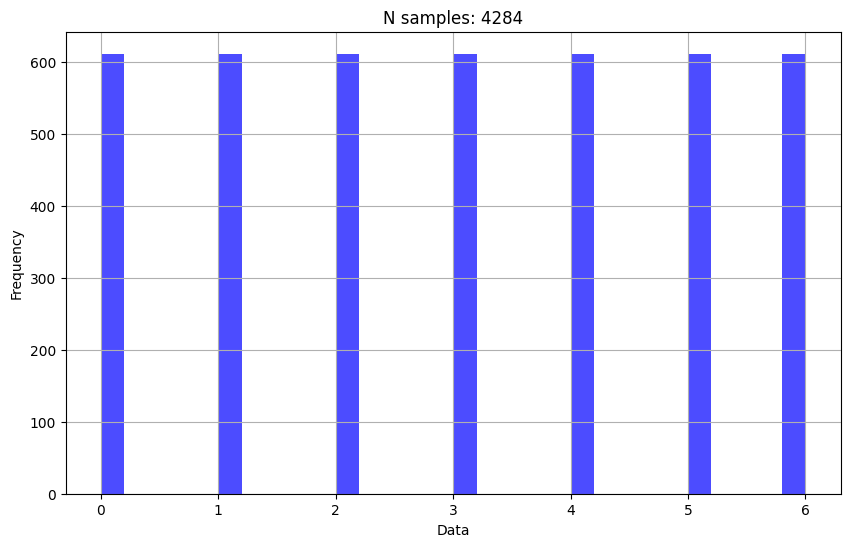

In [ ]:
Y = np.load('/home/user/Downloads/y_balanced_arousal_clean.npy')
X = np.squeeze(np.load('/home/user/Downloads/X_balanced_arousal_time_clean.npy'))
dataset = EpochsDataset((X, Y), savepath='../datasets/valence_all')
train, test = torch.utils.data.random_split(dataset, [.7, .3])
fig = plot_distribution(one_hot_decoder(Y), title=f'N samples: {len(dataset)}')

In [ ]:
X, Y = next(iter(DataLoader(train, 1)))

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'deepmeg.data.datasets.EpochsDataset'>

In [ ]:
X.shape, (X.min(), X.mean(), X.std(), X.max()), Y.shape, Y, torch.argmax(Y)

(torch.Size([1, 300, 5]),
 (tensor(-3.2018), tensor(-0.4701), tensor(0.8945), tensor(1.7951)),
 torch.Size([1, 7]),
 tensor([[0., 0., 0., 0., 0., 0., 1.]]),
 tensor(6))

In [ ]:
len(train), len(test)

(76, 32)

## Model

In [ ]:
class TinyNet(BaseModel):

    def __init__(
        self,
        input_size: int,
        encoder_hidden_size: int,
        decoder_hidden_size: int,
        attention_size: int,
        n_times: int,
        n_outputs: int
    ):
        super().__init__()
        self.linear = nn.Linear(n_times, n_times//10)
        self.attn_net = EncoderDecoderLSTM(
            input_size=input_size,
            encoder_hidden_size=encoder_hidden_size,
            decoder_hidden_size=decoder_hidden_size,
            attention_size=attention_size
        )
        self.fc_layer = nn.Linear(decoder_hidden_size*n_times//10, n_outputs)
        # self.fc_layer = nn.Linear(decoder_hidden_size*n_times, n_outputs)


    def forward(self, x: torch.Tensor):
        x = torch.permute(x, (0, 2, 1))
        x = self.linear(x)
        x = torch.permute(x, (0, 2, 1))
        x = self.attn_net(x)
        x = torch.flatten(x, 1)
        return self.fc_layer(x)


In [ ]:
X.shape, Y.shape

(torch.Size([316, 300, 5]), torch.Size([316, 7]))

In [ ]:
config = dict(
    input_size=X.shape[-1],
    encoder_hidden_size=3,
    decoder_hidden_size=3,
    attention_size=3,
    n_times=X.shape[1],
    n_outputs=Y.shape[-1]
)

In [ ]:
Y.shape[-1]

7

In [ ]:
model = TinyNet(
    **config
)

optimizer = torch.optim.AdamW

# loss = torch.nn.BCEWithLogitsLoss()
loss = torch.nn.CrossEntropyLoss()
    # weight=torch.tensor([
    #     1., # 0
    #     1., # 1
    #     1., # 2
    #     .5, # 3
    #     .5, # 4
    #     1., # 5
    #     1., # 6
    # ])
# )

metric = accuracy

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(),
        EarlyStopping(monitor='loss_train', patience=30, restore_best_weights=False),
        # L2Reg(
        #     ['linear.weight', 'attn_net.encoder_lstm.weight_hh_l0'],
        #     .001,
        # )
    ]
)

In [ ]:
dict(model.named_parameters()).keys()

dict_keys(['attn_net.encoder_lstm.weight_ih_l0', 'attn_net.encoder_lstm.weight_hh_l0', 'attn_net.encoder_lstm.bias_ih_l0', 'attn_net.encoder_lstm.bias_hh_l0', 'attn_net.attention.bias', 'attn_net.attention.W_enc.weight', 'attn_net.attention.W_enc.bias', 'attn_net.attention.W_dec.weight', 'attn_net.attention.W_dec.bias', 'attn_net.attention.V.weight', 'attn_net.attention.V.bias', 'attn_net.decoder_lstm.weight_ih', 'attn_net.decoder_lstm.weight_hh', 'attn_net.decoder_lstm.bias_ih', 'attn_net.decoder_lstm.bias_hh', 'fc_layer.weight', 'fc_layer.bias'])

In [ ]:
import sys

if hasattr(sys.stdout, 'file'):
  sys.stdout = sys.stdout.file

In [ ]:
history = model.fit(train, n_epochs=1500, batch_size=400, val_batch_size=200)
plot_metrics(history)

  0%|          | 0/1500 [00:00<?, ?it/s]
default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'deepmeg.data.datasets.EpochsDataset'>


Traceback (most recent call last):
  File "c:\Users\Tobii\Projects\oasisnn\venv\Lib\site-packages\deepmeg\training\trainers.py", line 351, in fit
    train_metrics = self.fit_epoch(train_loader, update_every_n_batches)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Tobii\Projects\oasisnn\venv\Lib\site-packages\deepmeg\training\trainers.py", line 288, in fit_epoch
    batch_metrics = self.fit_batch(train_iterator, update_every_n_batches)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Tobii\Projects\oasisnn\venv\Lib\site-packages\deepmeg\training\trainers.py", line 219, in fit_batch
    xs, ys_true = next(train_iterator)
                  ^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Tobii\Projects\oasisnn\venv\Lib\site-packages\torch\utils\data\dataloader.py", line 633, in __next__
    data = self._next_data()
           ^^^^^^^^^^^^^^^^^
  File "c:\Users\Tobii\Projects\oasisnn\venv\Lib\site-packages\torch\u

AttributeError: 'NoneType' object has no attribute 'items'

In [ ]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'deepmeg.data.datasets.EpochsDataset'>

In [ ]:
X_test, Y_test = next(iter(DataLoader(test, len(test))))
print(set(one_hot_decoder(Y_test)))


Preds_test = model(X_test)

sources = torch.permute(X_test, (0, 2, 1))
sources = model.linear(sources)
sources = torch.permute(sources, (0, 2, 1))

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'deepmeg.data.datasets.EpochsDataset'>

Text(0.5, 1.0, 'sample 774, class 4, pred 5')

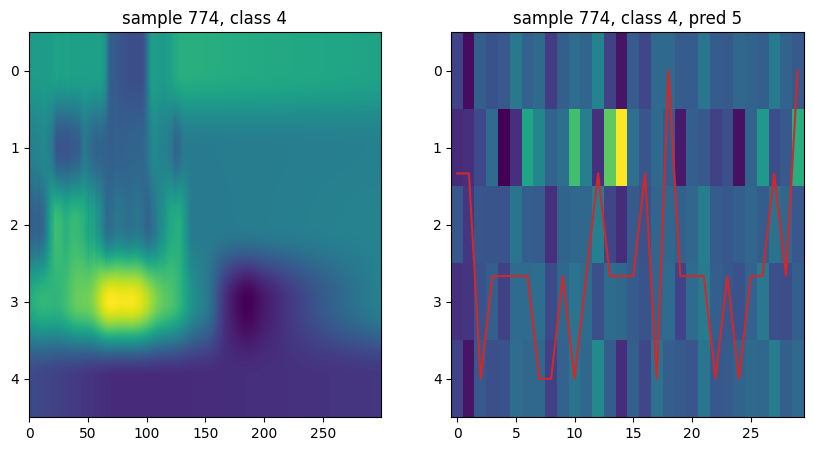

In [ ]:
n = np.random.randint(0, len(test))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
attn_w = torch.stack(model.attn_net.attention_weights)[:, n].detach().numpy()
ax1.imshow(X_test[n].T, aspect='auto')
label = np.argmax(Y_test[n]).item()
ax1.set_title(f'sample {n}, class {label}')
# ax1.imshow(attn_w, zorder=1)
ax2.imshow(sources.detach().numpy().mean(0).T, zorder=1, aspect='auto')
attn_tc = attn_w.mean(1)
ax2.plot((attn_tc - attn_tc.min())/(attn_tc.max() - attn_tc.min())*(sources.shape[-1] - 1), zorder=2, color='tab:red')
ax2.set_title(f'sample {n}, class {label}, pred {np.argmax(Preds_test[n].detach())}')

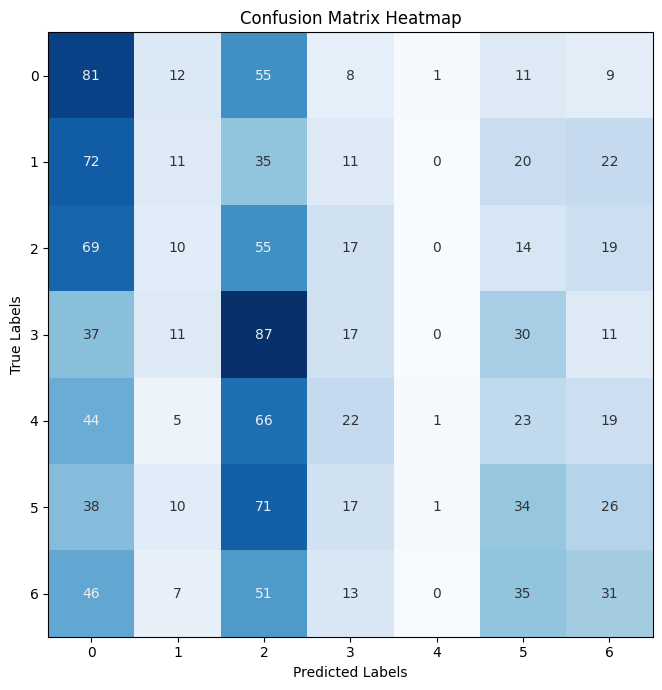

In [ ]:
conf_matrix_data = compute_confusion_matrix(
    one_hot_decoder(Y_test), one_hot_decoder(Preds_test)
)

confusion_matrix_df = pd.DataFrame(
    conf_matrix_data,
    index = conf_matrix_data.keys(),
    columns = conf_matrix_data.keys()
)

# Visualize the confusion matrix with color-coded text
fig = plot_confusion_matrix(confusion_matrix_df)
